# **Analysis of the influence of aquaculture pond construction on mangrove forests in Asian countries.**

## Introduction
Almost one third of the world's mangrove forests have been lost due to deforestation in the last 50 years (Alongi, 2002; Barbier, 2014). Along with coastal development, another major cause of global mangrove deforestation is the development of shrimp farms to support a booming export fishing industry (Barbier and Cox, 2004; Hamilton, 2020; Richards and Friess, 2016), with global demand for shrimp continuing to rise (Anderson et al., 2019). A study by Hamilton (2013) found that 51.9% of the original mangrove areas have been deforested between the 1970s and after 2004, with commercial aquaculture accounting for 28% of the total mangrove loss in eight countries: Indonesia, Brazil, Bangladesh, India, Thailand, Vietnam, Ecuador and China.

This notebook series studies the influence of aquaculture pond construction on mangrove forests through spatial analysis of two datasets: Aquaculture dynamics (Ottinger et al., 2021) and the Global Mangrove Watch version 3 (Bunting et al., 2018; Bunting, Rosenqvist, Hilarides, Lucas, & Thomas, 2022; Bunting, Rosenqvist, Hilarides, Lucas, Thomas, et al., 2022).

The general objective is to look for a relationship between the activation or construction of aquaculture ponds and the loss of mangrove forest extent. For this purpose, several notebooks were made for the different steps in the analysis process:


1. DataPreparation: The datasets are divided by countries in Asia and the layers are organised in separate folders.
2.   DataAnalysis: We proceed to analyse the relationship between both datasets using geoprocessing tools and working with dataframes.
MangroveChangeAnalysis: Only the Global Mangrove Watch dataset is analysed and an analysis of the dynamics within Asia is made.
4. GraphicOutput: The results of the analysis are visualised for interpretation and understanding.
5.   HexagonMangrove: Mapping the cumulative mangrove forest loss from 1996 to 2020 in the ten countries with the highest mangrove loss in Asia.
6.   HexagonPonds: Mapping cumulative mangrove loss due to pond construction from 1996 to 2019.


# Notebooks 2: Analysis of the relationship between the mangrove dataset and aquaculture ponds

In this notebook, a series of geospatial analyses are carried out to explore the interactions between aquaculture ponds and mangrove forests in various Asian countries. The datasets for both ponds and mangrove extents are sorted into dedicated folders for each country.

Overrall Methodology

We commence by loading the essential layers for the ponds and mangroves. These layers are then reprojected to a coordinate system with units in meters, facilitating subsequent spatial analyses.

The next phase involves the intersection of pond and mangrove layers for each available year. This process results in the creation of several new columns, capturing key metrics like intersecting area and binary indicators based on area thresholds.

Following the spatial intersection, a temporal analysis is conducted to identify the years in which mangrove coverage experiences a decrease directly attributable to pond construction. This is captured in a special column named dis_act, which logs the years of mangrove loss under specific conditions.

Lastly, the notebook calculates the areas of mangrove loss due to pond construction. This calculation is conditioned on the existence of specific temporal patterns in the dis_act column, ensuring the relevance of the calculated losses.



## 2.1. Data Initialization & Loading the ponds layer

First, we'll import the required GeoPandas library, which helps in dealing with spatial data. Since we are working in this case with Google Colab, we give our notebooks access to the googledrive where our folders created in the previous code are. These folders were created with the previous notebook 1.

In [ ]:
#Import geopanda library
import geopandas as gpd

#Connecting the google drive folder to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We'll start by reading the ponds polygon layer and reproject. The layer contains information about the ponds in the study region.It has several columns related to the ponds but we are going to work with the ones that have the number of the year in which these ponds were activated. The process of activation although recorded in a specific year is a process that occurs over a longer period of time as sometimes the area was deforested, then dams were built preparing the land and then activated showing a clear water mirror. This can be seen in the following figures which show how in one pond site in Myanmar the process of construction takes place in mangrove forest areas and how this manifests itself in the database used. Each polygon represents a pond where the columns with the year number have different values. The value one represents inactive and the value zero represents inactive. Other values and statuses exist but are not relevant for the purpose of this analysis.

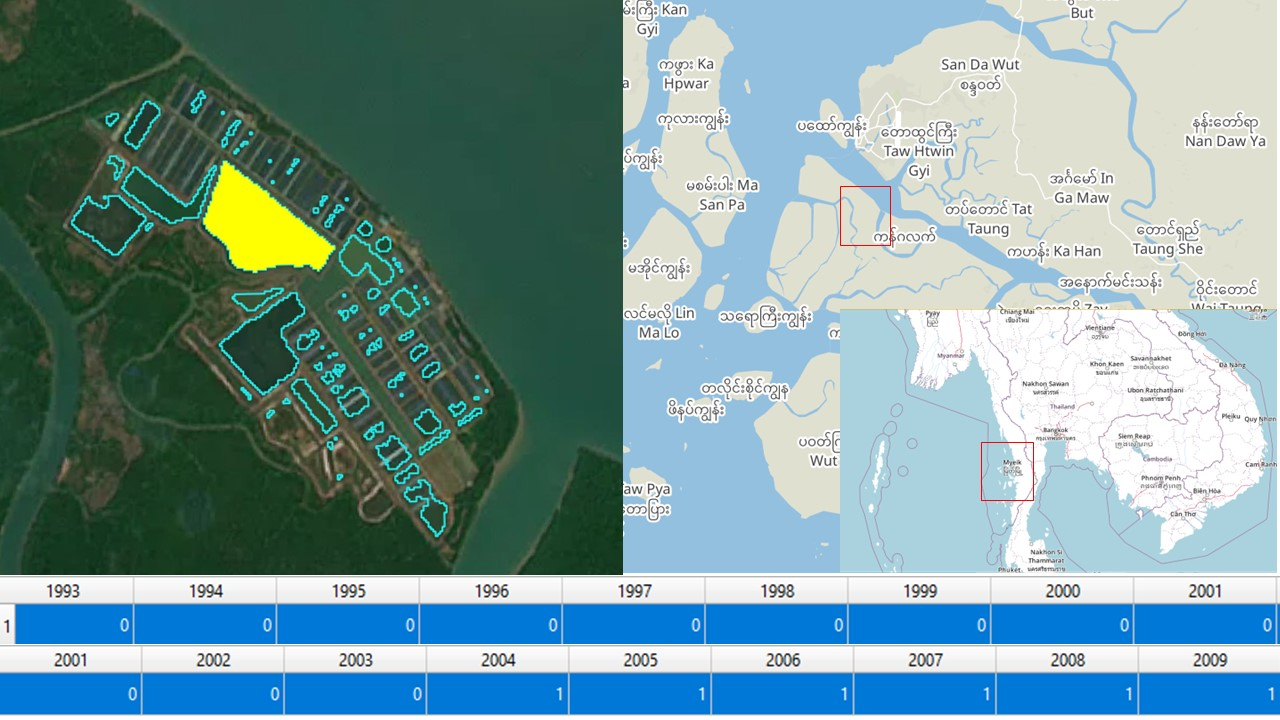



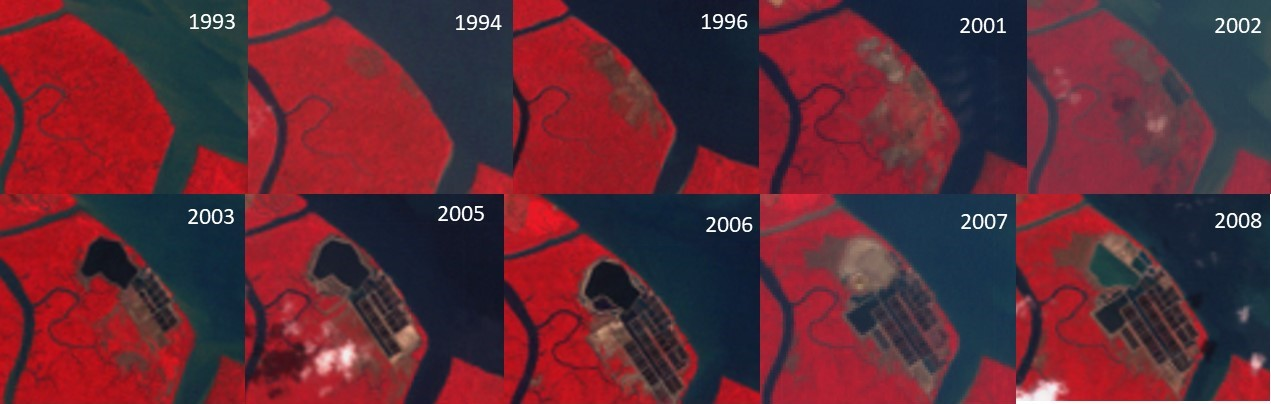

When loading the ponds layer and creating a GeoDataframe with it, we will transform the projection to one that uses meters as unit of measurement. This is necessary to be able to perform spatial analysis such as area calculation among others. The geodataframe is also created with a column of unique values to be used as a reference when making spatial joins and intercepts. When converting to Geodataframe format the ID column created in the shp or gpkg files is often lost.

In [ ]:
# Read the ponds polygon layer and projected in a projection that use meters.In this case we use EPSG:3857.
# WGS 84 / Pseudo-Mercator -- Spherical Mercator, Google Maps, OpenStreetMap, Bing, ArcGIS, ESRI
ponds_layer = gpd.read_file("/content/drive/MyDrive/colab_data/Countries/China/ponds_china.gpkg").to_crs(3857)

# Create a unique identifier for each pond
ponds_layer['pond_id'] = range(len(ponds_layer))

## 2.2. Spatial relation between Ponds and Mangroves dataset over the Years

We have layers of mangrove extension for some years from the Global Mangrove Watch version 3 which we will use to establish a relationship between the ponds dynamics with the mangrove forest extension dynamics. But unfortunately the mangrove dataset has 11 years of analysis and not continuous as it has two large gaps, between the years 1996 and 2007 and between 2010 and 2015. That is one of the limitation of this analysis which will be discussed later. However, this is the only region-wide dataset with more years of analysis that exists to date and trend-focused analyses can be valid and revealing results can be obtained.

In the code, we first define the years in which we are going to perform the analysis. Then we create a loop that will be repeated for all the years starting with the loading of the mangrove layers and their projection to EPSG:3857. Then we filter the type of geometry to use only the polygons, this avoids an error that can be generated when some layers contain more than one type of geometry. Then we proceed to the intersepcion between both layers, in this way we determine the area of mangroves that are within each pond polygon. A column is created with the year number and the prefix ma (e.g. "ma1996") where the area of mangrove within the pond boundaries for each year is stored. Then with this information we create a column where we define if the mangrove extent within each pond is "significant". In this case we define significant extent as if it exceeds 50% of the total area of the pond. That is, if the mangrove forest covers more than half of the pond. This criterion allows us to eliminate from the analysis ponds that are only partially covered by mangrove forests, which is often due to the error between the datasets. It should be noted that both datasets were developed with different methodologies and resolutions. Therefore, the consistency in boundaries and extent often has overlapping errors.

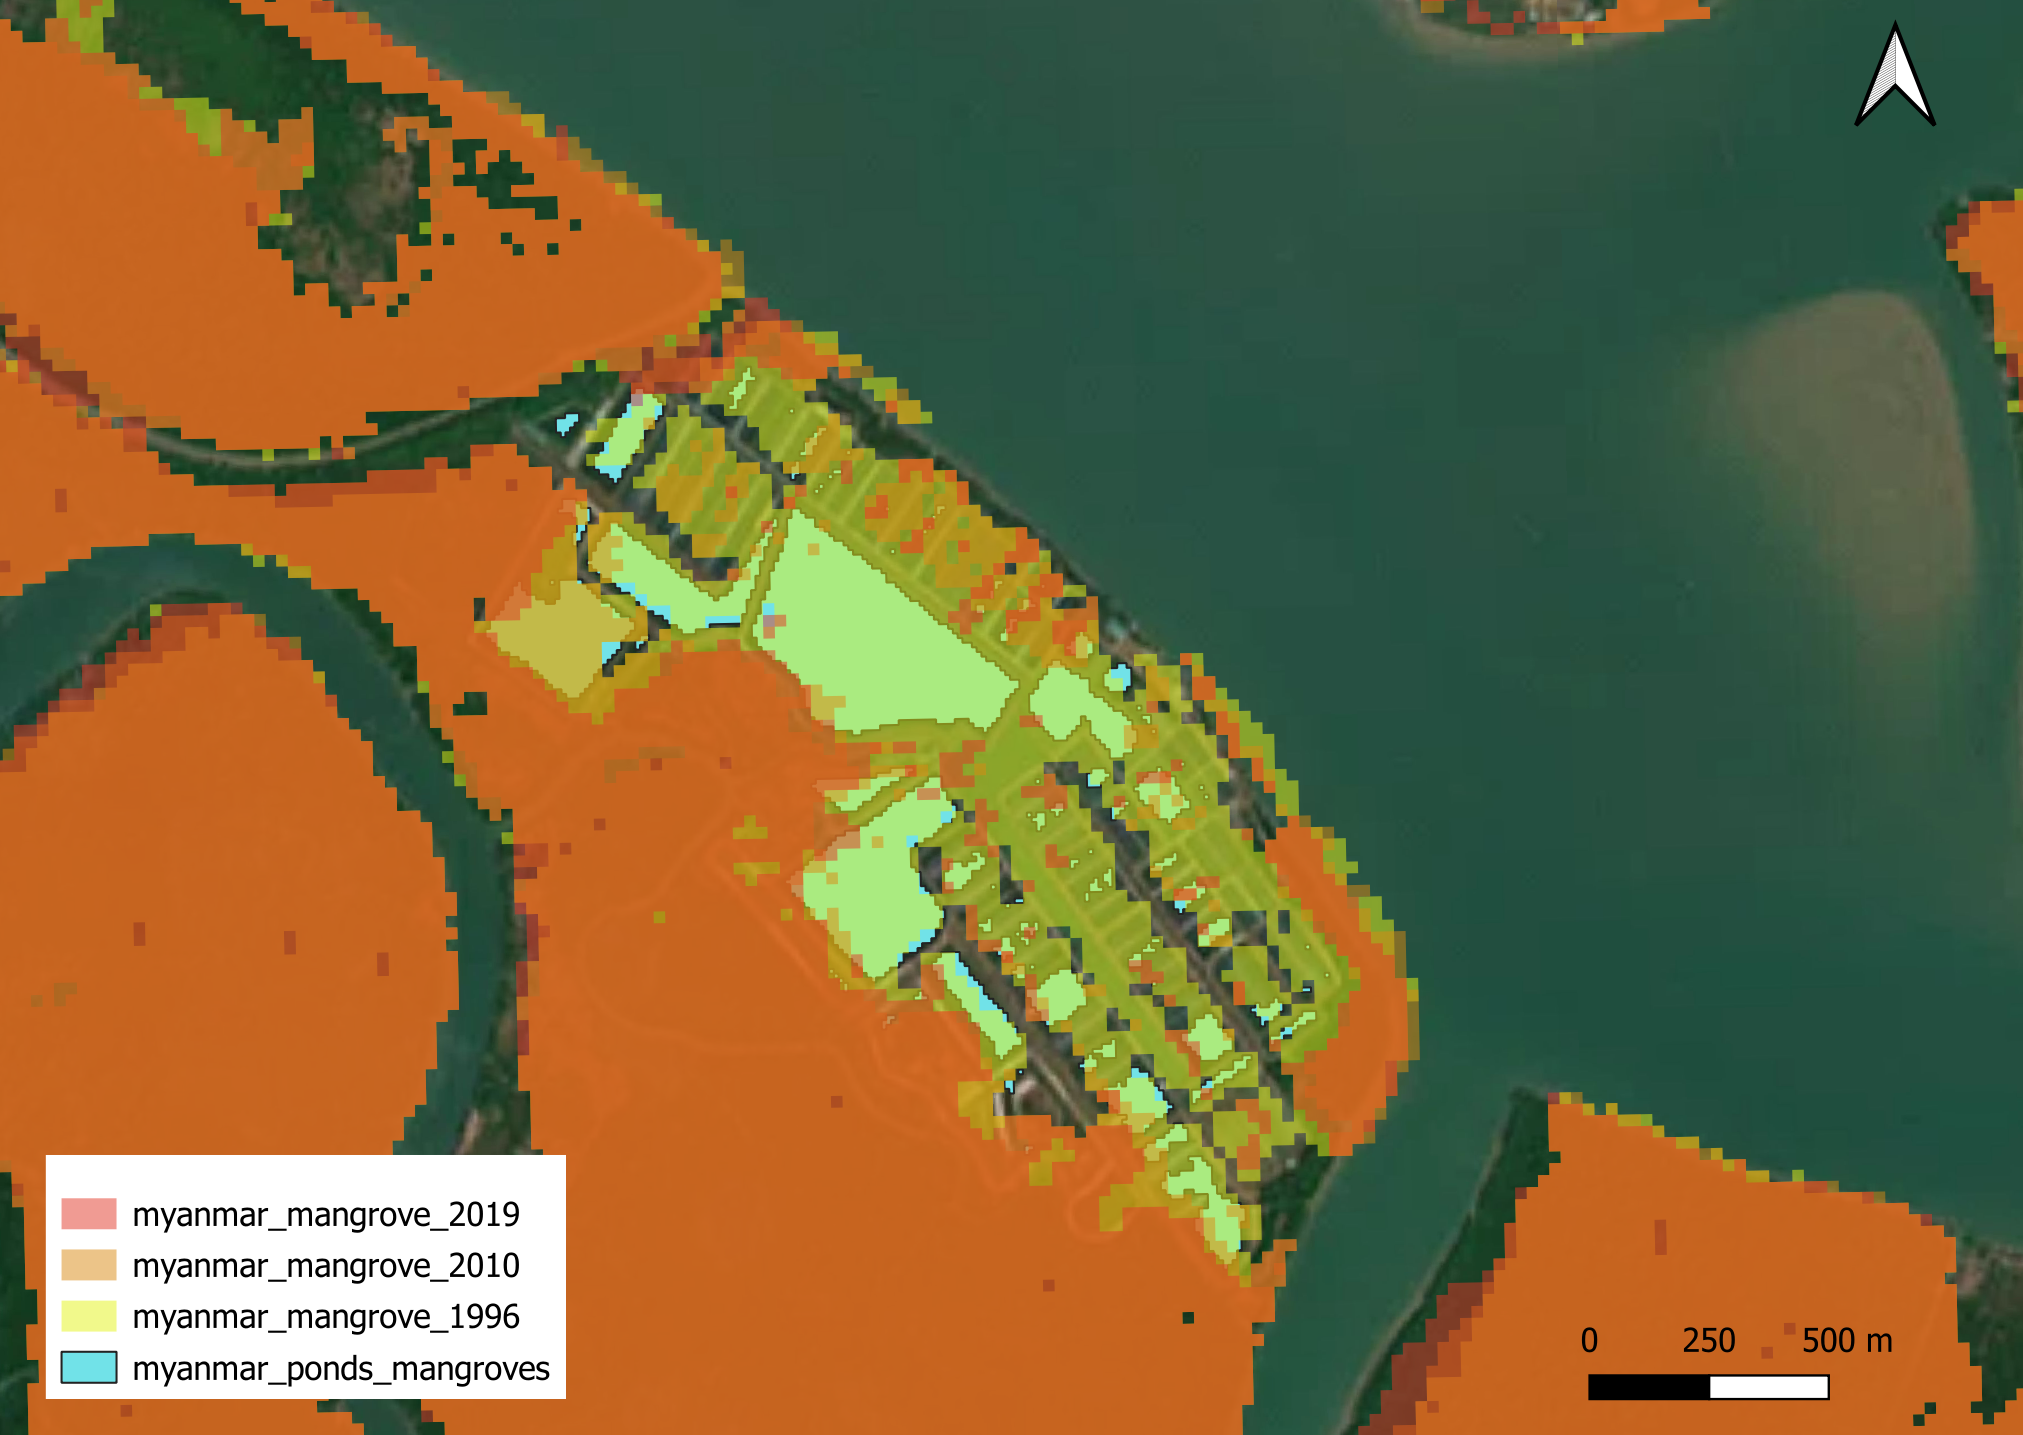

In [ ]:
# List of years
years = [1996, 2007, 2008, 2009, 2010, 2015, 2016, 2017, 2018, 2019]

for year in years:
    # Read the mangrove polygon layer for the specific year
    mangrove_layer = gpd.read_file(f"/content/drive/MyDrive/colab_data/Countries/China/mangrove_{year}.gpkg").to_crs(3857)

    # Filter to keep only Polygon geometries
    mangrove_layer = mangrove_layer[mangrove_layer.geometry.type == 'Polygon']

    # Perform spatial intersection
    intersect = gpd.overlay(ponds_layer, mangrove_layer, how='intersection')

    # Calculate the area of intersection and group by the unique pond identifier
    intersect['intersect_area'] = intersect['geometry'].area
    intersect_area_by_pond = intersect.groupby('pond_id')['intersect_area'].sum().reset_index()

    # Merge the intersection area back to the original ponds layer using the unique identifier
    ponds_layer = ponds_layer.merge(intersect_area_by_pond, on='pond_id', how='left')

    # Rename the merged intersect_area column
    ponds_layer.rename(columns={'intersect_area': f'ma{year}'}, inplace=True)  # Prefix "ma" added

    # Fill missing values with 0 for ponds that have no mangroves intersecting
    ponds_layer[f'ma{year}'] = ponds_layer[f'ma{year}'].fillna(0)

    # Calculate the area of the ponds if not already calculated
    if 'ponds_area' not in ponds_layer.columns:
        ponds_layer['ponds_area'] = ponds_layer['geometry'].area

    # Create a new column to check if the intersect area is more than half of the ponds area
    ponds_layer[f'm{year}'] = (ponds_layer[f'ma{year}'] > (0.5 * ponds_layer['ponds_area'])).astype(int)


The result is a column with the prefix "m" before the number of the year where we find the value 1 if in that year the mangrove covered more than half of the pond and 0 if it covered less. These columns will be used to carry out the other temporary analyses.

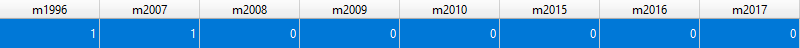

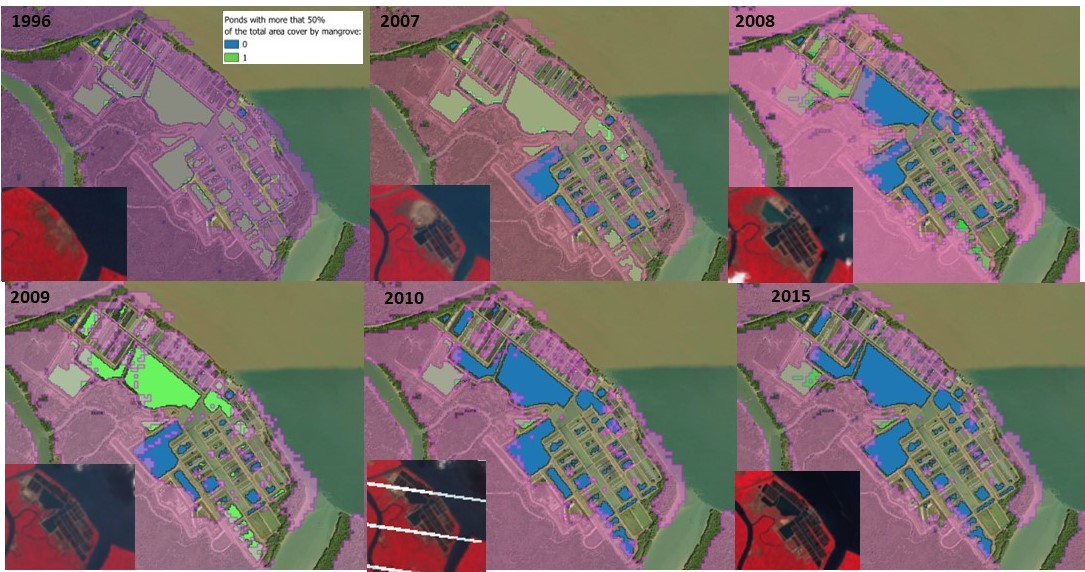

## 2.3. Temporal analysis between the activation of the ponds and the disappearance of the mangroves.

In this section we will determine the years of pond activation and the years where the mangrove extent decreased by more than half of the total pond area because the activation of the ponds. These breakpoints can be seen in the columns we have been working on so far. The criteria for the pond to change from inactive 0 to active 1 is defined in the publication XXXX, while the criteria for the case of the mangrove layer was defined in the previous step.

Two columns are first created in the code where the year of pond activation ['activation_position'] and the year of disappearance of mangrove cover by more than half of the pond area ['disappearance_position'] are stored. Instead of the year, were used the position it occupies in the list where these are defined. Por ejemplo, el ano 1996 ocupa la posicion 0 mientras por ejemplo el ano 2007 ocupa el 1. We decide to use the position due to the gaps between the years 1996-2007 and 2010-2015, avoiding errors in the analysis. If this is not done, the criteria for defining the causality of mangrove disappearance to the ponds would be too extended in time.

Only the first occurrence will be recorded, so the oscillations in the activation of the ponds and the decrease in cover will not be recorded. This is because we want to find the relationship between the construction and start-up of the pond and the disappearance or decrease in mangrove cover and not the other way round. This has the limitation of not taking into account the cases in which the pond, in certain intermediate years, stops being exploited and the mangrove begins to colonise it and then disappears again due to the rehabilitation of the pond.



In [ ]:
# Initialize new columns to store the results
ponds_layer['activation_position'] = None
ponds_layer['disappearance_position'] = None

# Iterate through the DataFrame by index
for idx, row in ponds_layer.iterrows():
    activation_position = None
    disappearance_position = None

    # Check the position of the first activation
    for i in range(len(years) - 1):
        if row[str(years[i])] == 0 and row[str(years[i + 1])] == 1:
            activation_position = i + 1
            break

    # Check the position of the first disappearance
    for i in range(len(years) - 1):
        if row['m' + str(years[i])] == 1 and row['m' + str(years[i + 1])] == 0:
            disappearance_position = i + 1
            break

    # Record the positions in the new columns
    ponds_layer.at[idx, 'activation_position'] = activation_position
    ponds_layer.at[idx, 'disappearance_position'] = disappearance_position


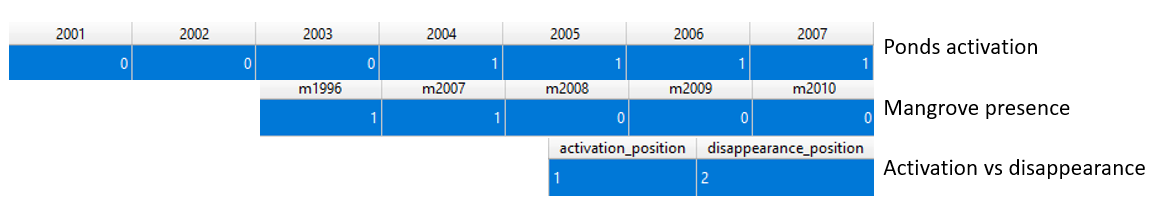

Now we will identify the year in which the mangrove disappeared but only due to the activation of the pond. For this, the criterion for causality of mangrove decline due to pond activation that was employed was as follows:
 "*Decline in mangrove extent is considered to have been caused by pond activation if and only if the change occurred less than two years after activation*".
For this we created a rule that uses the previously created columns of year of activation and disappearance. The causality criterion was taken as two positions before the disappearance position, but this can be changed at the discretion of the expert.


In [ ]:
# Initialize new column to store the results
ponds_layer['dis_act'] = None

# Iterate through the DataFrame by index
for idx, row in ponds_layer.iterrows():
    activation_position = row['activation_position']
    disappearance_position = row['disappearance_position']

    # Check if the activation position is available
    if activation_position is not None:
        # Check if the disappearance position is available and if the difference is between 0 and 2
        if disappearance_position is not None and 0 <= (disappearance_position - activation_position) <= 2:
            # Record the disappearance year in the new column
            ponds_layer.at[idx, 'dis_act'] = years[disappearance_position]


The result of the analysis is a new column with the year of the mangrove disappearance.

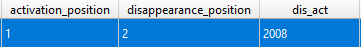

## 2.4. Analysis of the mangrove area lost due to the construction of the ponds.


In this section we finalize our analysis by calculating the amount of mangrove forest area lost directly by the construction or activation of aquaculture ponds. With the mangrove area columns created above we calculate the difference in mangrove area within the pond between the year (position) prior to activation and the year of disappearance, i.e. it decreased by more than half with respect to the total pond area. This takes into account not only the effect of the activation but also the previous affectations due to the construction or maintenance of the pond. The result is a new column with the area in meters of mangrove loss within the pond.

In [ ]:
# Initialize new column to store the results
ponds_layer['area_difference'] = 0

# Iterate through the DataFrame by index
for idx, row in ponds_layer.iterrows():
    activation_position = row['activation_position']
    disappearance_year = row['dis_act']  # Directly use the year from the 'dis_act' column

    # Check if both 'dis_act' and 'activation_position' are available
    if activation_position is not None and disappearance_year is not None:
        # Retrieve the corresponding activation year
        activation_year = years[activation_position]

        # Determine the year (position) before activation or use the same if it's the first year
        if activation_position > 0:
            year_before_activation = years[activation_position - 1]
        else:
            year_before_activation = years[activation_position]

        # Retrieve the mangrove area for both relevant years
        area_before_activation = row[f'ma{year_before_activation}']
        disappearance_area = row[f'ma{disappearance_year}']  # Use the year from 'dis_act'

        # Calculate the difference in area and store it in the new column
        area_difference = area_before_activation - disappearance_area
        ponds_layer.at[idx, 'area_difference'] = area_difference




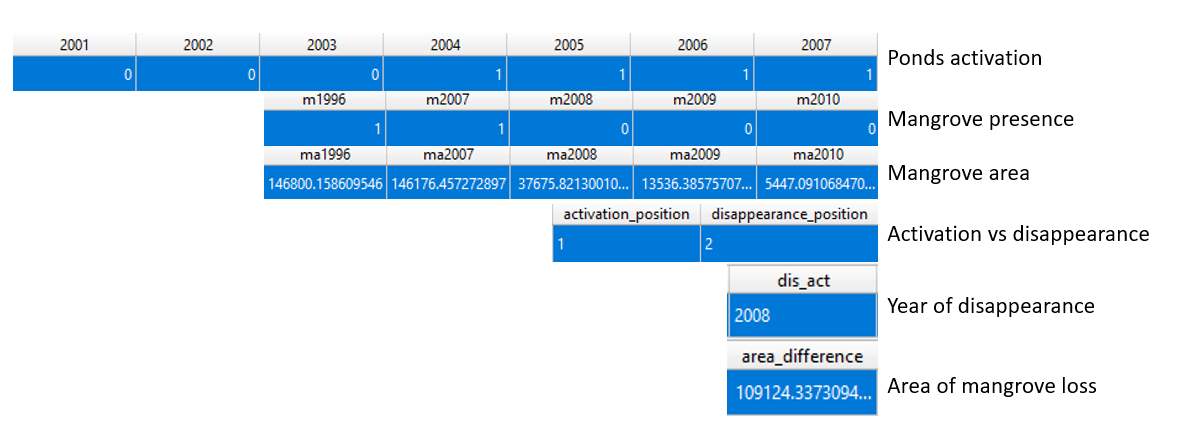

## Saving the New Layer

Finally, we'll save the new layer that contains the relationship between ponds and mangroves with all the columns for the next analysis between countries.

In [ ]:
# Save the new layer
ponds_layer.to_file('/content/drive/MyDrive/colab_data/Countries/Vietnam/Viet_ponds_mangroves.gpkg', driver='GPKG')